# Bayesian Optimization with black-box constraints
*Joachim van der Herten*

This notebook demonstrates the optimization of an analytical function using the well known Expected Improvement (EI) function. The problem is constrained by a black-box constraint function. The feasible regions are learnt jointly with the optimal regions by considering a second acquisition function known as the Probability of Feasibility (PoF), following the approach of Gardner et al. (2014)

In [1]:
%matplotlib inline
from matplotlib import rc
rc('text', usetex=True)
import matplotlib.pyplot as plt


import GPflow
import GPflowOpt
import numpy as np

First we set up an objective function (the townsend function) and a constraint function. We further assume both functions are black-box. We also define the optimization domain (2 continuous parameters).

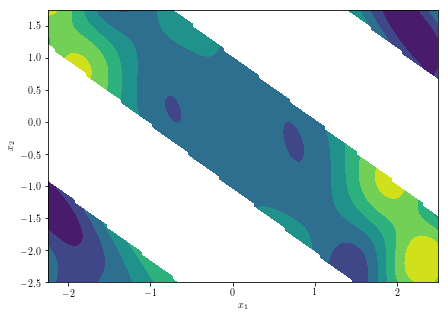

In [2]:
# Objective & constraint
def townsend(X):
    return -(np.cos((X[:,0]-0.1)*X[:,1])**2 + X[:,0] * np.sin(3*X[:,0]+X[:,1]))[:,None]

def constraint(X):
    return -(-np.cos(1.5*X[:,0]+np.pi)*np.cos(1.5*X[:,1])+np.sin(1.5*X[:,0]+np.pi)*np.sin(1.5*X[:,1]))[:,None]

# Setup input domain
domain = GPflowOpt.domain.ContinuousParameter('x1', -2.25, 2.5) + \
         GPflowOpt.domain.ContinuousParameter('x2', -2.5, 1.75)

# Plot
def plotfx():  
    X = GPflowOpt.design.FactorialDesign(101, domain).generate()
    Zo = townsend(X)
    Zc = constraint(X)
    mask = Zc>=0
    Zc[mask] = np.nan
    Zc[np.logical_not(mask)] = 1
    Z = Zo * Zc
    shape = (101, 101)

    f, axes = plt.subplots(1, 1, figsize=(7, 5))
    axes.contourf(X[:,0].reshape(shape), X[:,1].reshape(shape), Z.reshape(shape))
    axes.set_xlabel('$x_1$')
    axes.set_ylabel('$x_2$')
    axes.set_xlim([domain.lower[0], domain.upper[0]])
    axes.set_ylim([domain.lower[1], domain.upper[1]])
    return axes

plotfx();

We proceed by assigning the objective and constraint function a GP prior. Both functions are evaluated on a space-filling set of points (here, a Latin Hypercube design). Two GPR models are created.
The EI is based on the model of the objective function (townsend), whereas PoF is based on the model of the constraint function. We then define the joint criterioin as the product of the EI and PoF.

In [3]:
# Initial evaluations
design = GPflowOpt.design.LatinHyperCube(11, domain)
X = design.generate()
Yo = townsend(X)
Yc = constraint(X)

# Models
objective_model = GPflow.gpr.GPR(X, Yo, GPflow.kernels.Matern52(2, ARD=True))
constraint_model = GPflow.gpr.GPR(X, Yc, GPflow.kernels.Matern52(2, ARD=True))

# Setup
ei = GPflowOpt.acquisition.ExpectedImprovement(objective_model)
pof = GPflowOpt.acquisition.ProbabilityOfFeasibility(constraint_model)
joint = ei * pof

We can now inspect our belief about the optimization problem by plotting the models, the EI, PoF and joint mappings. Both models clearly are not very accurate yet. More specifically, the constraint model does not correctly capture the feasibility yet.

name.kern.lengthscales transform:+ve prior:None
[ 0.20071154  0.16473314]
name.kern.variance transform:+ve prior:None
[ 0.11357407]
name.likelihood.variance transform:+ve prior:None
[ 0.68554072]



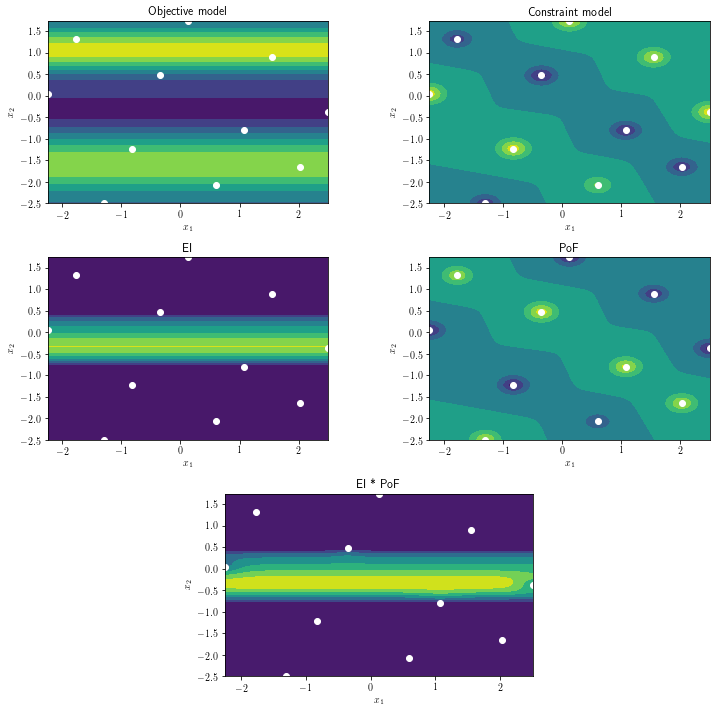

In [4]:
def plot():
    Xeval = GPflowOpt.design.FactorialDesign(101, domain).generate()
    Yevala,_ = objective_model.predict_f(Xeval)
    Yevalb,_ = constraint_model.predict_f(Xeval)
    Yevalc = np.maximum(ei.evaluate(Xeval), 0)
    Yevald = pof.evaluate(Xeval)
    Yevale = np.maximum(joint.evaluate(Xeval), 0)
    shape = (101, 101)
    plots = [('Objective model', Yevala), ('Constraint model', Yevalb), 
             ('EI', Yevalc), ('PoF', Yevald), 
             ('EI * PoF', Yevale)]

    plt.figure(figsize=(10,10))
    for i, plot in enumerate(plots):
        if i == 4:
            plt.subplot(3,3,8)
            ax = plt.subplot2grid((3, 4), (2, 1), colspan=2)
        else:
            ax = plt.subplot2grid((3, 2), (int(i/2), i % 2))
            
        ax.contourf(Xeval[:,0].reshape(shape), Xeval[:,1].reshape(shape), plot[1].reshape(shape))
        ax.scatter(joint.data[0][:,0], joint.data[0][:,1], c='w')
        ax.set_title(plot[0])
        ax.set_xlabel('$x_1$')
        ax.set_ylabel('$x_2$')
        ax.set_xlim([domain.lower[0], domain.upper[0]])
        ax.set_ylim([domain.lower[1], domain.upper[1]])
    plt.tight_layout()
    
# Plot representing the model belief, and the belief mapped to EI and PoF
plot()
print(constraint_model)

Running the Bayesian optimization is the next step. For this, we must set up an appropriate strategy to optimize the joint acquisition function. Sometimes this can be a bit challenging as often large non-varying areas may occur. A typical strategy is to apply a Monte Carlo optimization step first, then optimize the point with the best value (several variations exist). This approach is followed here. We then run the Bayesian Optimization and allow it to select up to 50 additional decisions. 

The joint acquisition function assures the feasibility (w.r.t the constraint) is taken into account while selecting decisions for optimality.

In [5]:
# First setup the optimization strategy for the acquisition function
# Combining MC step followed by L-BFGS-B
acquisition_opt = GPflowOpt.optim.StagedOptimizer([GPflowOpt.optim.MCOptimizer(domain, 200), 
                                                   GPflowOpt.optim.SciPyOptimizer(domain)])

# Then run the BayesianOptimizer for 50 iterations
optimizer = GPflowOpt.BayesianOptimizer(domain, joint, optimizer=acquisition_opt)
optimizer.optimize([townsend, constraint], n_iter=50)

     fun: array([-1.65951073])
 message: 'OK'
    nfev: 50
 success: True
       x: array([[ 0.75274388, -0.32413296]])

If we now plot the belief, we clearly see the constraint model has improved significantly. More specifically, its PoF mapping is an accurate representation of the true constraint function. By multiplying the EI by the PoF, the search is restricted to the feasible regions.

name.kern.lengthscales transform:+ve prior:None
[ 1.54446512  1.39038155]
name.kern.variance transform:+ve prior:None
[ 1.35389228]
name.likelihood.variance transform:+ve prior:None
[  1.00000003e-06]



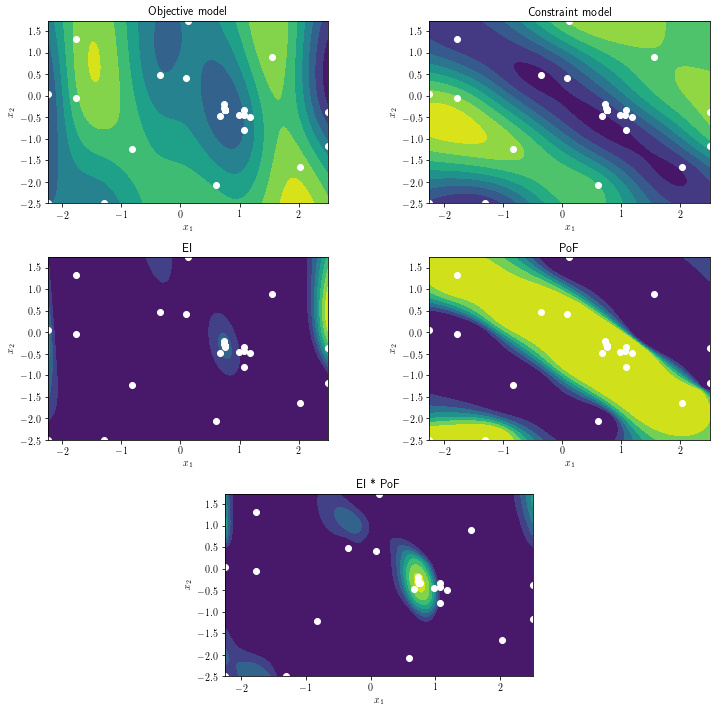

In [6]:
# Plotting belief again
print(constraint_model)
plot()

If we inspect the sampling distribution, we can see that the amount of samples in the infeasible regions is limited. The optimization has focussed on the feasible areas. In addition, it has been active mostly in two optimal regions.

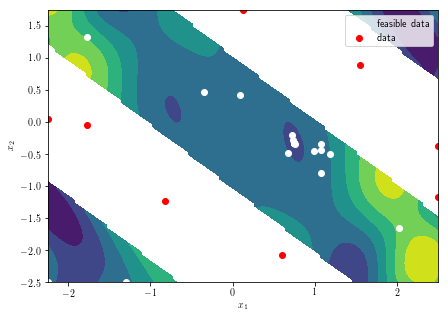

In [7]:
# Plot function, overlayed by the constraint. Also plot the samples
axes = plotfx()
valid = joint.feasible_data_index()
axes.scatter(joint.data[0][valid,0], joint.data[0][valid,1], label='feasible data', c='w')
axes.scatter(joint.data[0][np.logical_not(valid),0], joint.data[0][np.logical_not(valid),1], label='data', c='r');
axes.legend()

Finally, the evolution of the best value over the number of iterations clearly shows a very good solution is already found after only a few evaluations.

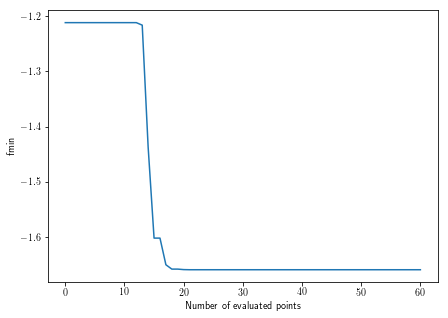

In [8]:
f, axes = plt.subplots(1, 1, figsize=(7, 5))
f = joint.data[1][:,0]
f[joint.data[1][:,1] > 0] = np.inf
axes.plot(np.arange(0, joint.data[0].shape[0]), np.minimum.accumulate(f))
axes.set_ylabel('fmin')
axes.set_xlabel('Number of evaluated points');